# This code images the orbital collocations between saildrone and SMAP for both RSS and JPL 
-there are 13 saildrone cruises


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import scipy
from glob import glob
import cartopy.crs as ccrs
from pyresample.geometry import AreaDefinition
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition
from pyresample.kd_tree import resample_nearest
import sys
sys.path.append('../saildrone/subroutines/')
from read_routines import read_one_usv, add_coll_vars,get_filelist_l2p,get_orbital_data_l2p
import warnings
warnings.simplefilter('ignore') # filter some warning messages


# Read in USV data
Read in the Saildrone USV file either from a local disc or using OpenDAP.



In [2]:
dir_data = 'f:/data/cruise_data/saildrone/saildrone_data/'
dir_data_pattern = 'f:/data/cruise_data/saildrone/saildrone_data/*west*.nc' 

#get list of all filenames in directory
files = glob(dir_data_pattern)
print('number of file:',len(files))
for ifile,file in enumerate(files):
    print(ifile,file)

number of file: 13
0 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2018_sd1024.nc
1 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2018_sd1025.nc
2 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2018_sd1026.nc
3 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2018_sd1027.nc
4 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2018_sd1028.nc
5 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2019_sd1038.nc
6 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2019_sd1039.nc
7 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2019_sd1040.nc
8 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2019_sd1043.nc
9 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2019_sd1044.nc
10 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2019_

In [3]:
#filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
#filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
iname=0
ds_usv=[]
for file in files:
    ds = read_one_usv(file)
    ds_usv.append(ds[0])
ds_usv=xr.concat(ds_usv,dim='trajectory')
#ds_usv = xr.open_mfdataset(files,concat_dim='trajectory')
#ds_usv.close()
#ds_usv = ds_usv.isel(trajectory=0).swap_dims({'obs':'time'}).rename({'longitude':'lon','latitude':'lat'})
#ds_usv = ds_usv.sel(time=slice('2018-04-12T02','2018-06-10T18')) #get rid of last part and first part where USV being towed
#ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear') #there are 6 nan values
#ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear')
ds_usv['wind_speed']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)
ds_usv['wind_dir']=np.arctan2(ds_usv.VWND_MEAN,ds_usv.UWND_MEAN)*180/np.pi
#ds_usv

In [4]:
ds_usv

<xarray.Dataset>
Dimensions:                       (time: 350468, trajectory: 13)
Coordinates:
  * time                          (time) datetime64[ns] 2018-06-27 ... 2019-0...
  * trajectory                    (trajectory) object '1024.0' ... 1.047e+03
Data variables: (12/27)
    lat                           (trajectory, time) float64 nan nan ... nan nan
    lon                           (trajectory, time) float64 nan nan ... nan nan
    SOG_MEAN                      (trajectory, time) float64 nan nan ... nan nan
    COG_MEAN                      (trajectory, time) float64 nan nan ... nan nan
    HDG_MEAN                      (trajectory, time) float64 nan nan ... nan nan
    PITCH_MEAN                    (trajectory, time) float64 nan nan ... nan nan
    ...                            ...
    TEMP_O2_RBR_MEAN              (trajectory, time) float64 nan nan ... nan nan
    CDOM_MEAN                     (trajectory, time) float64 nan nan ... nan nan
    CHLOR_WETLABS_MEAN            (trajectory, time) float64 nan nan ... nan nan
    WIND_MEASUREMENT_HEIGHT_MEAN  (trajectory, time) float64 nan nan ... nan nan
    wind_speed                    (trajectory, time) float64 nan nan ... nan nan
    wind_dir                      (trajectory, time) float64 nan nan ... nan nan
Attributes: (12/47)
    area:                      unassigned
    cdm_data_type:             Trajectory
    cdm_trajectory_variables:  trajectory
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             support@saildrone.com
    creator_name:              Saildrone
    ...                        ...
    time_coverage_resolution:  PT1M
    time_coverage_start:       2018-07-17T18:00:00Z
    title:                     Saildrone West Coast Survey 2018
    uuid:                      3e4ce677-18db-4ba8-9c73-f2c1f3ad15ce
    Westernmost_Easting:       -124.915008
    vehicle_id:                sd1024

# image salinity for all 13 cruises

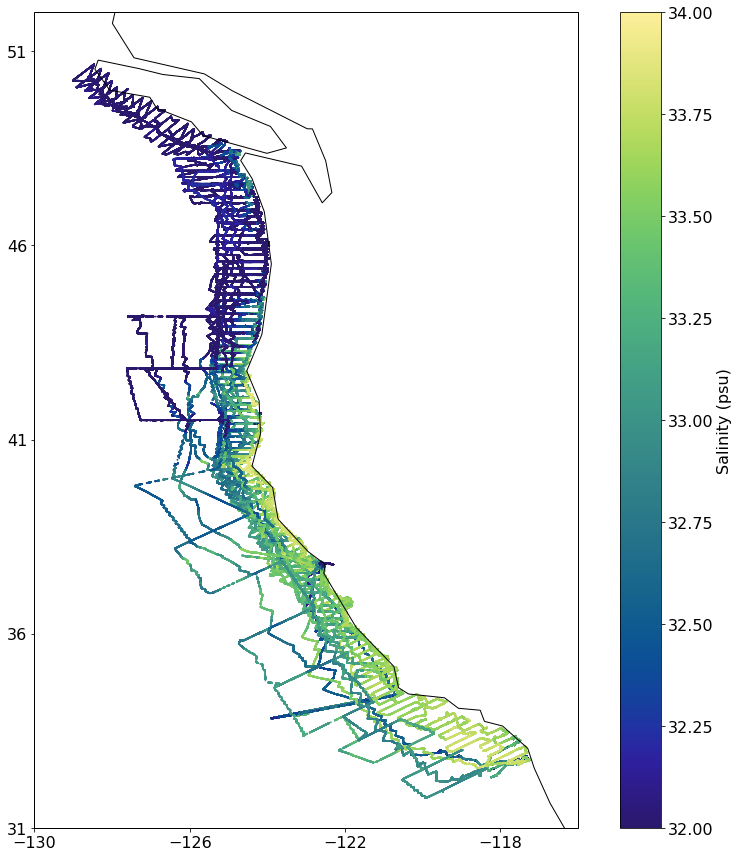

In [5]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.rcParams.update({'font.size': 16})
import cmocean
for i in range(len(ds_usv.trajectory)):
    ds=ds_usv.isel(trajectory=i)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.SAL_CTD_MEAN, edgecolor='none', cmap=cmocean.cm.haline,vmin=32,vmax=34)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Salinity (psu)',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_all_cruises.png'
plt.savefig(fig_fname, transparent=False, format='png')

this figure show all the salinity data from the west coast cruises. Salinity is higher from about cape mendocino down towards baja. upwelling results in cool (SST) salty (SSS) water near the coasts and this is seen by the higher salinity values near land.

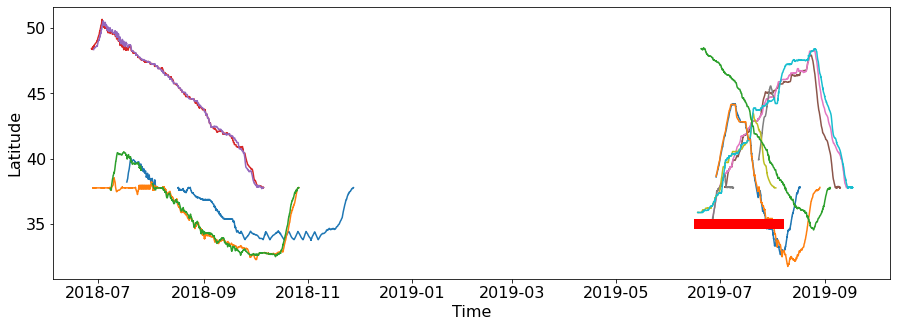

In [6]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 16})
import cmocean
for i in range(len(ds_usv.trajectory)):
    ds=ds_usv.isel(trajectory=i)
    #ax = plt.axes(projection=ccrs.PlateCarree())
    plt.plot(ds.time,ds.lat)
    plt.plot([np.datetime64('2019-06-19'),np.datetime64('2019-08-05')],[35,35],'r',linewidth=10) #DATA OUTAGE
plt.ylabel('Latitude')
plt.xlabel('Time')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_all_cruises_timeseries.png'
plt.savefig(fig_fname, transparent=False, format='png')

This figure shows the times and latitudes that saildrone cruises collected data. The red bar is when SMAP was offline and not returning data.  The Summer/Fall 2018 saildrone cruises sampled the entire coast, from Baja to Canada with 5 saildrones. The Summer 2019 cruises had 6 saildrone vehicle and while the SMAP data failure will not result in any data for about 1/2 of the cruise, the latter half of the cruise still covers the entire US coast.

# Now read in the collocated Saildrone - SMAP data

In [7]:
dir_data = 'F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat/' #'f:/data/cruise_data/saildrone/saildrone_data/'
dir_data_patternJ = 'F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat/*west*JPL*.nc' 
dir_data_patternR = 'F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat/*west*RSS*.nc' 

#get list of all filenames in directory
cfilesJ = glob(dir_data_patternJ)
cfilesR = glob(dir_data_patternR)
print('number of file:',len(cfilesJ))
print('number of file:',len(cfilesR))
for ifile,file in enumerate(cfilesJ):
    print(ifile,file)

number of file: 13
number of file: 13
0 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1024jplv05.0_orbitalnorep.nc
1 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1025jplv05.0_orbitalnorep.nc
2 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1026jplv05.0_orbitalnorep.nc
3 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1027jplv05.0_orbitalnorep.nc
4 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1028jplv05.0_orbitalnorep.nc
5 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2019_sd1038jplv05.0_orbitalnorep.nc
6 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2019_sd1039jplv05.0_orbitalnorep.nc
7 F:/data/cruise_data/sa

In [8]:
ds2=[]
for i in range(len(cfilesJ)):
    print(i,cfilesJ[i])
    ds = xr.open_dataset(cfilesJ[i])
    ds2.append(ds)
ds_colJ = xr.concat(ds2,dim='trajectory')
ds2=[]
for i in range(len(cfilesR)):
    ds = xr.open_dataset(cfilesR[i])
    ds2.append(ds)
ds_colR = xr.concat(ds2,dim='trajectory')
ds_colR['wind_speed']=np.sqrt(ds_colR.UWND_MEAN**2+ds_colR.VWND_MEAN**2)
ds_colJ['wind_speed']=np.sqrt(ds_colJ.UWND_MEAN**2+ds_colJ.VWND_MEAN**2)


0 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1024jplv05.0_orbitalnorep.nc
1 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1025jplv05.0_orbitalnorep.nc
2 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1026jplv05.0_orbitalnorep.nc
3 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1027jplv05.0_orbitalnorep.nc
4 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1028jplv05.0_orbitalnorep.nc
5 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2019_sd1038jplv05.0_orbitalnorep.nc
6 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2019_sd1039jplv05.0_orbitalnorep.nc
7 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_n

In [9]:
ds_colJ

<xarray.Dataset>
Dimensions:                       (ob: 324, trajectory: 13)
Coordinates:
  * ob                            (ob) int64 0 1 2 3 4 5 ... 319 320 321 322 323
  * trajectory                    (trajectory) object '1024.0' ... 1.047e+03
Data variables: (12/37)
    lat                           (trajectory, ob) float64 38.23 38.24 ... nan
    lon                           (trajectory, ob) float64 -123.9 -124.0 ... nan
    SOG_MEAN                      (trajectory, ob) float64 1.539 1.505 ... nan
    COG_MEAN                      (trajectory, ob) float64 279.1 283.6 ... nan
    HDG_MEAN                      (trajectory, ob) float64 287.2 291.7 ... nan
    PITCH_MEAN                    (trajectory, ob) float64 2.697 2.714 ... nan
    ...                            ...
    smap_ydim                     (trajectory, ob) float32 18.0 19.0 ... nan nan
    smap_xdim                     (trajectory, ob) float32 1.04e+03 ... nan
    smap_rev_number               (trajectory, ob) float64 1.847e+04 ... nan
    dist_land                     (trajectory, ob) float64 65.26 66.82 ... nan
    time                          (trajectory, ob) datetime64[ns] 2018-07-17T...
    wind_speed                    (trajectory, ob) float64 8.607 8.603 ... nan
Attributes: (12/47)
    area:                      unassigned
    cdm_data_type:             Trajectory
    cdm_trajectory_variables:  trajectory
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             support@saildrone.com
    creator_name:              Saildrone
    ...                        ...
    time_coverage_resolution:  PT1M
    time_coverage_start:       2018-07-17T18:00:00Z
    title:                     Saildrone West Coast Survey 2018
    uuid:                      3e4ce677-18db-4ba8-9c73-f2c1f3ad15ce
    Westernmost_Easting:       -124.915008
    vehicle_id:                sd1024

In [10]:
ds_colR

<xarray.Dataset>
Dimensions:                       (ob: 306, trajectory: 13)
Coordinates:
  * ob                            (ob) int64 0 1 2 3 4 5 ... 301 302 303 304 305
  * trajectory                    (trajectory) object '1024.0' ... 1.047e+03
Data variables: (12/38)
    lat                           (trajectory, ob) float64 38.24 38.25 ... nan
    lon                           (trajectory, ob) float64 -124.0 -124.0 ... nan
    SOG_MEAN                      (trajectory, ob) float64 1.573 1.695 ... nan
    COG_MEAN                      (trajectory, ob) float64 280.8 289.4 ... nan
    HDG_MEAN                      (trajectory, ob) float64 289.0 296.1 ... nan
    PITCH_MEAN                    (trajectory, ob) float64 2.744 3.123 ... nan
    ...                            ...
    smap_ydim                     (trajectory, ob) float32 512.0 512.0 ... nan
    smap_xdim                     (trajectory, ob) float32 405.0 ... nan
    smap_rev_number               (trajectory, ob) float64 1.848e+04 ... nan
    dist_land                     (trajectory, ob) float64 66.22 70.48 ... nan
    time                          (trajectory, ob) datetime64[ns] 2018-07-17T...
    wind_speed                    (trajectory, ob) float64 8.684 9.125 ... nan
Attributes: (12/47)
    area:                      unassigned
    cdm_data_type:             Trajectory
    cdm_trajectory_variables:  trajectory
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             support@saildrone.com
    creator_name:              Saildrone
    ...                        ...
    time_coverage_resolution:  PT1M
    time_coverage_start:       2018-07-17T18:00:00Z
    title:                     Saildrone West Coast Survey 2018
    uuid:                      3e4ce677-18db-4ba8-9c73-f2c1f3ad15ce
    Westernmost_Easting:       -124.915008
    vehicle_id:                sd1024

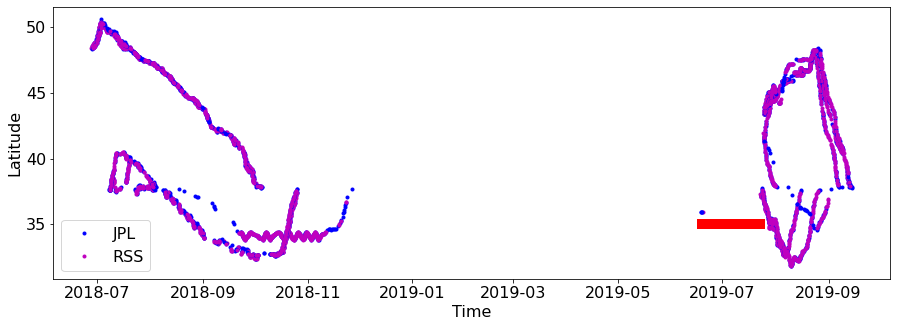

In [17]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 16})
import cmocean
for i in range(len(ds_usv.trajectory)):
    ds=ds_colJ.isel(trajectory=i)
    if i==0:
        plt.plot(ds.time,ds.lat,'.',color='b',linewidth=3,label='JPL')
    else:
        plt.plot(ds.time,ds.lat,'.',color='b',linewidth=3)        
    ds=ds_colR.isel(trajectory=i)
    if i==0:
        plt.plot(ds.time,ds.lat,'.',color='m',label='RSS')
    else:
        plt.plot(ds.time,ds.lat,'.',color='m')
    plt.plot([np.datetime64('2019-06-19'),np.datetime64('2019-07-23')],[35,35],'r',linewidth=10) #DATA OUTAGE
plt.ylabel('Latitude')
plt.xlabel('Time')
plt.legend()
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_coll_cruises_timeseriesJPL.png'
plt.savefig(fig_fname, transparent=False, format='png')

this figure shows the saildrone/SMAP collocations for both the JPL and RSS data by latitude and time. There are lots of collocations for the 2018 cruises and some for 2019, with a large gap during the SMAP data failure.

#Plot the collocations

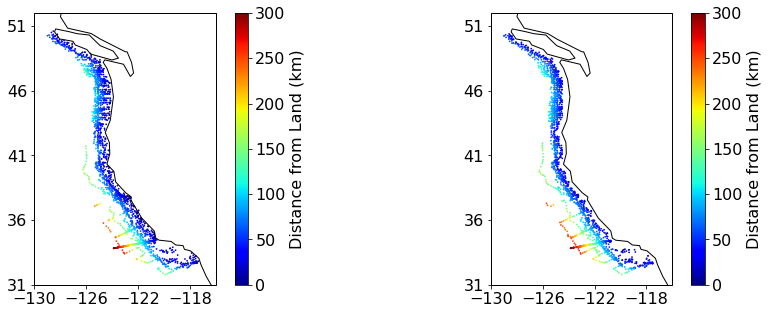

In [18]:
for i in range(13):
    ds=ds_colJ.isel(trajectory=i)
    ax = plt.subplot(121,projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.dist_land, edgecolor='none', cmap='jet',vmin=0,vmax=300)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Distance from Land (km)',fontsize=16)
for i in range(13):
    ds=ds_colR.isel(trajectory=i)
    ax = plt.subplot(122,projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.dist_land, edgecolor='none', cmap='jet',vmin=0,vmax=300)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Distance from Land (km)',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_distance.png'
plt.savefig(fig_fname, transparent=False, format='png')

This figure shows distance from land which we added to the collocation files.  You can see that it is working correctly. The largest distance saildrone goes is ~300km from land. This is for all collocations, both JPL and RSS, without any masking or flagging exclusion of collocations.

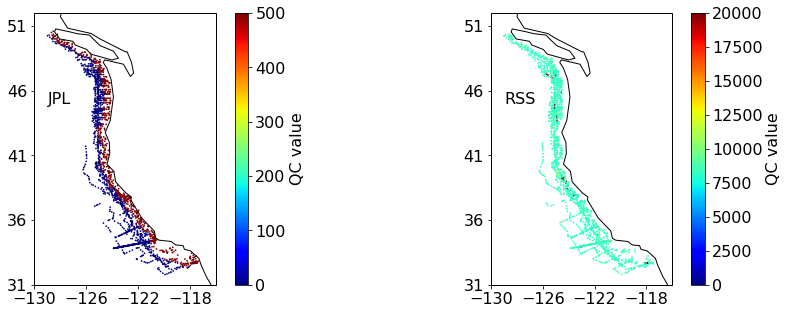

In [25]:
for i in range(13):
    ds=ds_colJ.isel(trajectory=i)
    ax = plt.subplot(121,projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.smap_iqc_flag, edgecolor='none', cmap='jet',vmin=0,vmax=500)
plt.text(-129,45,'JPL')
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('QC value',fontsize=16)
for i in range(13):
    ds=ds_colR.isel(trajectory=i)
    ax = plt.subplot(122,projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.smap_iqc_flag, edgecolor='none', cmap='jet',vmin=0,vmax=20000)
plt.text(-129,45,'RSS')
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('QC value',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_qc.png'
plt.savefig(fig_fname, transparent=False, format='png')

- JPL on left, near land flagged, 
- RSS on right, all dat flagged as light-land-contami - and some rain flags

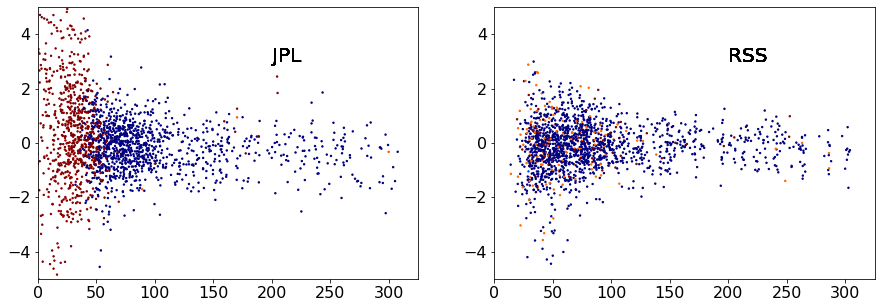

In [26]:
for i in range(13):
    ds=ds_colJ.isel(trajectory=i)
    #ds = ds.where( (ds.smap_iqc_flag<1))
    ax = plt.subplot(121)
    plt.scatter(ds.dist_land,ds.SAL_CTD_MEAN-ds.smap_SSS,s=2,c=ds.smap_iqc_flag,cmap='jet')
    plt.text(200,3,'JPL',fontsize=20)
    plt.xlim(0,325),plt.ylim(-5,5)
for i in range(13):
    ds=ds_colR.isel(trajectory=i)
    ds = ds.where((ds.SAL_CTD_MEAN>26) & (ds.smap_iqc_flag<10000))
    ax = plt.subplot(122)
    plt.scatter(ds.dist_land,ds.SAL_CTD_MEAN-ds.smap_SSS,s=2,c=ds.smap_iqc_flag,cmap='jet')
    plt.text(200,3,'RSS',fontsize=20)
    plt.xlim(0,325),plt.ylim(-5,5)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_distance_land.png'
plt.savefig(fig_fname, transparent=False, format='png')

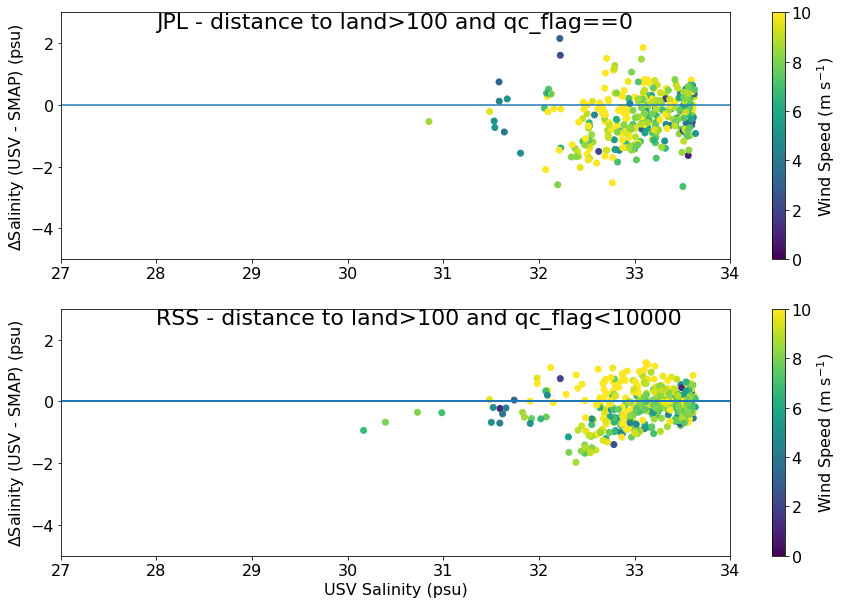

In [45]:
plt.rcParams['figure.figsize'] = (15.0,10.0)
plt.rcParams.update({'font.size': 16})
for i in range(13):
    ds = ds_colJ.isel(trajectory=i)
    ds = ds.where((ds.dist_land>100) & (ds.SAL_CTD_MEAN>26) & (ds.smap_iqc_flag<1)) #removes near land
    dif = ds.SAL_CTD_MEAN-ds.smap_SSS
    plt.subplot(2,1,1)
    cc=plt.scatter(ds.SAL_CTD_MEAN,dif,c=ds.wind_speed,vmin=0,vmax=10)
cb=plt.colorbar(label='Wind Speed (m s$^{-1}$)')
plt.axhline(0)
plt.text(28,2.5,'JPL - distance to land>100 and qc_flag==0',fontsize=22)
plt.xlim(27,34),plt.ylim(-5,3),plt.ylabel('$\Delta$Salinity (USV - SMAP) (psu)')
for i in range(13):
    ds = ds_colR.isel(trajectory=i)
    ds = ds.where((ds.dist_land>100) & (ds.smap_iqc_flag<10000)) #leaves in light land cont
    dif = ds.SAL_CTD_MEAN-ds.smap_SSS
    plt.subplot(2,1,2)
    plt.axhline(0)
    plt.scatter(ds.SAL_CTD_MEAN,dif,c=ds.wind_speed,vmin=0,vmax=10)
plt.text(28,2.5,'RSS - distance to land>100 and qc_flag<10000',fontsize=22)
plt.xlim(27,34),plt.ylim(-5,3),plt.ylabel('$\Delta$Salinity (USV - SMAP) (psu)'),plt.xlabel('USV Salinity (psu)')
cb=plt.colorbar(label='Wind Speed (m s$^{-1}$)')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_sal_scatter.png'
plt.savefig(fig_fname, transparent=False, format='png')

The figure above shows the scatter plot for salinity difference versus salinity. The color of the lines indicates wind speed. A slight salty bias is seen in the JPL data and a slightly larger scatter.

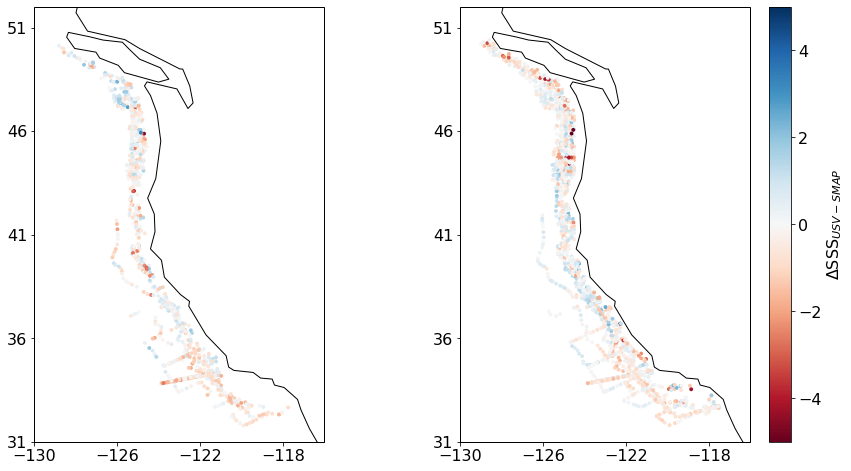

In [46]:
plt.rcParams['figure.figsize'] = (15.0,8.0)
plt.rcParams.update({'font.size': 16})

for i in range(13):
    ds=ds_colJ.isel(trajectory=i)
    ds = ds.where((ds.smap_iqc_flag<1))
#    ds = ds.where((ds.dist_land>25) & (ds.SAL_CTD_MEAN>26) & (ds.smap_iqc_flag<1))
    ax = plt.subplot(121,projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=15.0, c=ds.SAL_CTD_MEAN-ds.smap_SSS, edgecolor='none', cmap='RdBu',vmin=-5,vmax=5)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))

for i in range(13):
    ds=ds_colR.isel(trajectory=i)
    ds = ds.where((ds.smap_iqc_flag<10000))
    ax = plt.subplot(122,projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=15.0, c=ds.SAL_CTD_MEAN-ds.smap_SSS, edgecolor='none', cmap='RdBu',vmin=-5,vmax=5)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))

cax = plt.colorbar(cs1)
cax.set_label('$\Delta$SSS$_{USV-SMAP}$',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_sal_dif.png'
plt.savefig(fig_fname, transparent=False, format='png')

In [52]:
print('USV-SMAP, all data with qc_flags used')
ds=ds_colJ.where((ds_colJ.smap_iqc_flag<1))
ds['dif_sal']=ds.SAL_CTD_MEAN-ds.smap_SSS
print('JPL',ds.dif_sal.mean().data,ds.dif_sal.std().data,(ds.dif_sal/ds.dif_sal).sum().data)
ds=ds_colR.where( (ds_colR.smap_iqc_flag<10000))
ds['dif_sal']=ds.SAL_CTD_MEAN-ds.smap_SSS
print('RSS',ds.dif_sal.mean().data,ds.dif_sal.std().data,(ds.dif_sal/ds.dif_sal).sum().data)

print('   ')
print('USV-SMAP all data with qc_flags used plus distance to land>100')
ds=ds_colJ.where((ds_colJ.dist_land>100)  & (ds_colJ.smap_iqc_flag<1))
ds['dif_sal']=ds.SAL_CTD_MEAN-ds.smap_SSS
print('JPL',ds.dif_sal.mean().data,ds.dif_sal.std().data,(ds.dif_sal/ds.dif_sal).sum().data)
ds=ds_colR.where((ds_colR.dist_land>100) & (ds_colR.smap_iqc_flag<10000))
ds['dif_sal']=ds.SAL_CTD_MEAN-ds.smap_SSS
print('RSS',ds.dif_sal.mean().data,ds.dif_sal.std().data,(ds.dif_sal/ds.dif_sal).sum().data)

print('   ')
print('USV-SMAP all data with qc_flags used plus distance to land>150')
ds=ds_colJ.where((ds_colJ.dist_land>150)  & (ds_colJ.smap_iqc_flag<1))
ds['dif_sal']=ds.SAL_CTD_MEAN-ds.smap_SSS
print('JPL',ds.dif_sal.mean().data,ds.dif_sal.std().data,(ds.dif_sal/ds.dif_sal).sum().data)
ds=ds_colR.where((ds_colR.dist_land>150) & (ds_colR.smap_iqc_flag<10000))
ds['dif_sal']=ds.SAL_CTD_MEAN-ds.smap_SSS
print('RSS',ds.dif_sal.mean().data,ds.dif_sal.std().data,(ds.dif_sal/ds.dif_sal).sum().data)


USV-SMAP, all data with qc_flags used
JPL -0.20302986017057398 0.8782074041781945 993.0
RSS -0.1556086646876625 0.9211048081607605 1688.0
   
USV-SMAP all data with qc_flags used plus distance to land>100
JPL -0.33395970096286787 0.789066091312463 337.0
RSS -0.13421557445472046 0.5969931480470536 399.0
   
USV-SMAP all data with qc_flags used plus distance to land>150
JPL -0.399622510600645 0.7513292418945321 184.0
RSS -0.10855012600308674 0.5503931344039616 215.0


In [ ]:
#for i in range(13):
#    ds=ds_colJ.isel(trajectory=i)
#    ds = ds.where(ds.dist_land>30)
#    ax = plt.axes(projection=ccrs.PlateCarree())
#    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.dist_land, edgecolor='none', cmap='jet',vmin=0,vmax=300)
#ax.coastlines()
#cs1.set_fontsize(16)
#x1,x2,y1,y2 = -130,-116,31,52
#ax.set_xlim(x1,x2)
#ax.set_ylim(y1,y2)
#ax.set_xticks(np.arange(x1,x2,4))
#ax.set_yticks(np.arange(y1,y2,5))
#cax = plt.colorbar(cs1)
#cax.set_label('Distance from Land (km)',fontsize=16)
#fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_distanceJPL.png'
#plt.savefig(fig_fname, transparent=False, format='png')



